In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from glob import glob
from natsort import natsorted

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np

from matplotlib.colors import LogNorm

from astropy.stats import sigma_clipped_stats

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry
from photutils.background import Background2D

from astropy.stats import mad_std

import cometToolkit as ctk

from astropy.nddata import Cutout2D

In [2]:
mpl.rcParams.update({'font.size': 14})

# Finding ZeroPoint

In [68]:
Day = "Day14"
day = "day14"

vReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{Day}/V/*"))[:-2]
rReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{Day}/R/*"))[:-2]
bReducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/{Day}/B/*"))[:-2]

vStackedStars = ctk.StackImages(vReducedDataPaths, preserveAvgCounts=False)
rStackedStars = ctk.StackImages(rReducedDataPaths, preserveAvgCounts=False)
bStackedStars = ctk.StackImages(bReducedDataPaths, preserveAvgCounts=False)

(array([], dtype=int64),)
xcentroid ycentroid peak flux
--------- --------- ---- ----


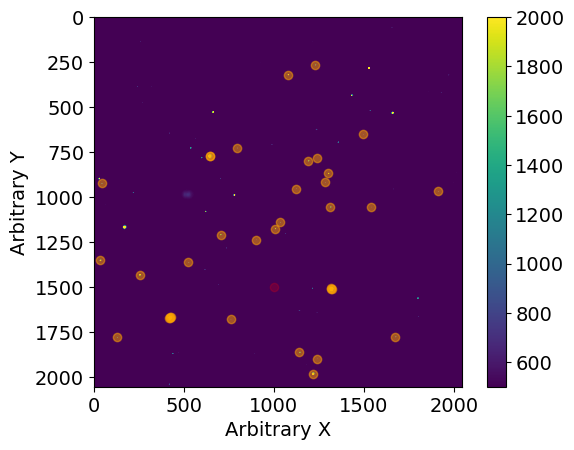

In [69]:
# Use to manually find star locations

image = vStackedStars

mean, median, std = sigma_clipped_stats(image, sigma=5.0)
background = median

sources = ctk.SearchStars(image - background, fwhm=3, threshold=5*std, showPlot=True)

plt.imshow(image, vmin=500, vmax=2000)
plt.colorbar()

# Finding stars
starCentre = (1000, 1500)
tolerance = 20
referenceStarIndices = np.where((abs(sources["xcentroid"] - starCentre[0]) < tolerance) & (abs(sources["ycentroid"] - starCentre[1]) < tolerance))
print(referenceStarIndices)
plt.scatter(sources[referenceStarIndices]["xcentroid"], sources[referenceStarIndices]["ycentroid"], alpha=0.5, color="orange")

plt.scatter(starCentre[0], starCentre[1], alpha=0.2, color="red")

print(sources[referenceStarIndices]["xcentroid", "ycentroid", "peak", "flux"])

In [70]:
# Calibration from APASS9
catalogDay12 = {
    "coordinates": np.array([(1720, 940), (1700, 1640)]),
    "vCalibratedMagnitudes": [12.376, 11.849],
    "bCalibratedMagnitudes": [12.932, 12.3],
    "sloan_r": [12.247, 11.75],
    "sloan_i": [12.077, 11.615]
}
catalogDay13 = {
    "coordinates": np.array([(115, 1420), (300, 1750)]),
    "vCalibratedMagnitudes": [16.25, 15.766],
    "bCalibratedMagnitudes": [16.763, 16.076],
    "sloan_r": [16.194, 15.649],
    "sloan_i": [15.713, 15.512]
}
catalogDay14 = {
    "coordinates": np.array([(1660, 530), (1650, 950)]),
    "vCalibratedMagnitudes": [13.073, 16.88],
    "bCalibratedMagnitudes": [13.647, 17.946],
    "sloan_r": [12.92, 16.617],
    "sloan_i": [12.735, 16.23]
}
catalogDay17 = {
    "coordinates": np.array([(110, 880), (130, 1600)]),
    "vCalibratedMagnitudes": [11.538, 13.919],
    "bCalibratedMagnitudes": [12.189, 15.119],
    "sloan_r": [11.357, 13.382],
    "sloan_i": [11.161, 12.887]
}

match Day:
    case "Day12": catalog = catalogDay12
    case "Day13": catalog = catalogDay13
    case "Day14": catalog = catalogDay14
    case "Day17": catalog = catalogDay17

[12.802999999999999, 16.5]


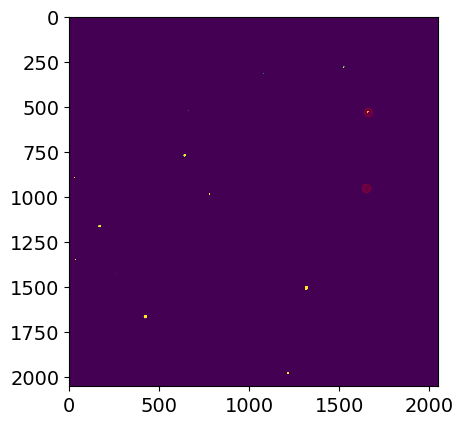

In [71]:
# Sloan r to Johnsons R
# Jordi et al.
# https://www.sdss3.org/dr8/algorithms/sdssUBVRITransform.php#Jordi2006
def JohnsonsR(sloan_r, sloan_i):
    # Note there are uncertainties on these transformations
    # Which can be included
    return -0.153 * (sloan_r - sloan_i) - 0.117 + sloan_r

catalog["rCalibratedMagnitudes"] = [JohnsonsR(r, i) for r, i in zip(catalog["sloan_r"], catalog["sloan_r"])]

print(catalog["rCalibratedMagnitudes"])

plt.imshow(vStackedStars, vmin=2000, vmax=3000)
plt.scatter(catalog["coordinates"][:,0], catalog["coordinates"][:,1], alpha=0.2, color="red")

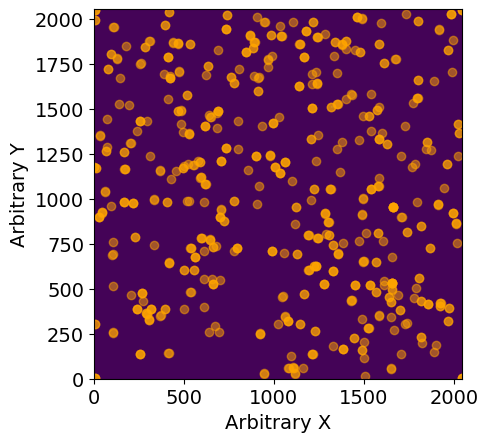

In [72]:

zpV = ctk.DetermineStarZeroPoint(vStackedStars, len(vReducedDataPaths), catalog["coordinates"], catalog["vCalibratedMagnitudes"], apertureRadius=10, showPlot=True)
zpR = ctk.DetermineStarZeroPoint(rStackedStars, len(rReducedDataPaths), catalog["coordinates"], catalog["rCalibratedMagnitudes"], apertureRadius=10, showPlot=True)
zpB = ctk.DetermineStarZeroPoint(bStackedStars, len(bReducedDataPaths), catalog["coordinates"], catalog["bCalibratedMagnitudes"], apertureRadius=10, showPlot=True)

vZeroPoint,vStd = (np.mean(zpV), np.std(zpV))
rZeroPoint,rStd = (np.mean(zpR), np.std(zpR)) 
bZeroPoint,bStd = (np.mean(zpB), np.std(zpB)) 

In [73]:
print(f"{vZeroPoint:.2f} +/- {vStd:.2f}")
print(f"{rZeroPoint:.2f} +/- {rStd:.2f}")
print(f"{bZeroPoint:.2f} +/- {bStd:.2f}")

20.43 +/- 0.05
20.98 +/- 0.16
19.47 +/- 0.11


# Aperture Curve

In [74]:
vImageStacked = ctk.GetImage(f"../DataProducts/StackedImages/{Day}/vStacked.fits")
rImageStacked = ctk.GetImage(f"../DataProducts/StackedImages/{Day}/rStacked.fits")
bImageStacked = ctk.GetImage(f"../DataProducts/StackedImages/{Day}/bStacked.fits")

In [75]:
def FindComet(image, showPlot=False):
    sources = ctk.SearchStars(image, showPlot=showPlot)

    tolerance = 20

    match Day:
        case "Day12": posX, posY = (570, 770)
        case "Day13": posX, posY = (570, 770)
        case "Day14": posX, posY = (490, 770)
        case "Day17": posX, posY = (570, 770)

    if showPlot:
        plt.scatter(posX, posY)
    

    indices = np.where((abs(sources["xcentroid"] - posX) < tolerance) & (abs(sources["ycentroid"] - posY) < tolerance))
    comet = sources[indices]

    print(comet)

    return (int(comet["xcentroid"].value), int(comet["ycentroid"].value))

cometV = FindComet(vImageStacked)
cometR = FindComet(rImageStacked)
cometB = FindComet(bImageStacked)

 id     xcentroid         ycentroid     ...        flux              mag        
--- ----------------- ----------------- ... ----------------- ------------------
 14 474.3621005438017 774.3963401131296 ... 94.79117786925839 -4.941919799542771


/tmp/ipykernel_51650/2598982032.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (int(comet["xcentroid"].value), int(comet["ycentroid"].value))


 id    xcentroid         ycentroid     ...        flux               mag        
--- ---------------- ----------------- ... ------------------ ------------------
 22 474.190905964029 774.5262159077861 ... 134.93014800730018 -5.325272491866517


/tmp/ipykernel_51650/2598982032.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (int(comet["xcentroid"].value), int(comet["ycentroid"].value))


 id     xcentroid     ...        flux               mag        
--- ----------------- ... ------------------ ------------------
 15 474.4787011006442 ... 48.550523076628686 -4.215484783244956


/tmp/ipykernel_51650/2598982032.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (int(comet["xcentroid"].value), int(comet["ycentroid"].value))


In [76]:
# Activity
from sbpy.data import Ephem
from sbpy.calib import solar_fluxd
from sbpy.activity import Afrho

import astropy.units as u

# Function to do this for range of apertures

In [77]:
def FindActivityCurve(image, comet, apertureRangeKm, zeroPoint, phase, exposureTime, zpApertureRadius=10, showPlot=False, vmin=0, vmax=80):
    
    activity = []
    activityError = []
    # CHANGE TO VARIABLE DISTANCE
    cometDistance = 0.585 * 1.496e8 # au to km

    # Find background
    mean, median, std = sigma_clipped_stats(image, sigma=5.0)
    background = median

    sources = ctk.SearchStars(image - background)
    tolerance = 20
    indices = np.where((abs(sources["xcentroid"] - comet[0]) < tolerance) & (abs(sources["ycentroid"] - comet[1]) < tolerance))
    peakFlux = sources[indices]["peak"][0]

    if showPlot:
        # Plot
        fig, ax = plt.subplots()

        ax.imshow(image - background, vmin=vmin, vmax=vmax)

    for aKm in apertureRangeKm:
        # Convert aperture range from km to pixel
        aPixel = (180 * 3600) / (0.6 * np.pi) * np.arctan2(aKm, cometDistance)

        # Create aperture
        aperture = CircularAperture((comet[0], comet[1]), r=aPixel)

        if showPlot:
            apertureCircle = plt.Circle((comet[0], comet[1]), aPixel, color="white", fill = 0)

            ax.add_patch(apertureCircle)

        phot_table = aperture_photometry(image - background, aperture)
        
        # find magnitude within aperture
        mag = -2.5 * np.log10(phot_table["aperture_sum"] / exposureTime) + zeroPoint[0]

        snr = peakFlux / np.sqrt(peakFlux + aPixel * median)
        magError = (1 / snr + zeroPoint[1]) * u.ABmag

        wavelength = 0.5501 * u.um

        mag = mag[0] * u.ABmag # absolute magnitude
        magUpper = (mag.value - magError.value) * u.ABmag
        magLower = (mag.value + magError.value) * u.ABmag

        aper = aKm * u.km

        eph = Ephem.from_dict({"rh": 1.566 * u.au, "delta": 0.585 * u.au})

        afrho = Afrho.from_fluxd(wavelength, mag, aper, eph)
        upper = Afrho.from_fluxd(wavelength, magUpper, aper, eph)
        lower = Afrho.from_fluxd(wavelength, magLower, aper, eph)
        
        afrho_phaseCorrected = afrho.to_phase(0 * u.deg, phase * u.deg)
        upper_phaseCorrected = upper.to_phase(0 * u.deg, phase * u.deg)
        lower_phaseCorrected = lower.to_phase(0 * u.deg, phase * u.deg)

        activity.append(afrho_phaseCorrected.value)
        activityError.append((upper.value - lower.value) / 2)

    return [apertureRangeKm, activity, activityError]

In [78]:
apertureRange = np.linspace(1000, 70000, 40)

match Day:
    case "Day12": phase = 9.63 # degrees
    case "Day13": phase = 9.07
    case "Day14": phase = 8.64
    case "Day17": phase = 7.5


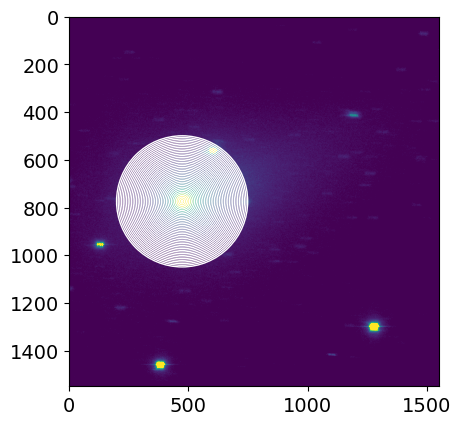

In [79]:
apRange, activityV, activityVError = FindActivityCurve(vImageStacked, cometV, apertureRange, zeroPoint=[vZeroPoint, vStd], phase=phase, exposureTime=len(vReducedDataPaths)*120, showPlot=True)

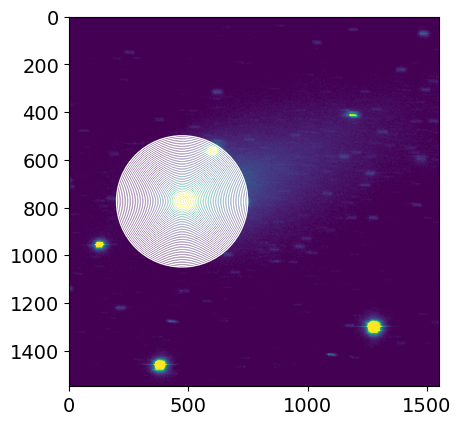

In [80]:
apRange, activityR, activityRError = FindActivityCurve(rImageStacked, cometR, apertureRange, zeroPoint=[rZeroPoint, rStd], phase=phase, exposureTime=len(vReducedDataPaths)*120, showPlot=True)

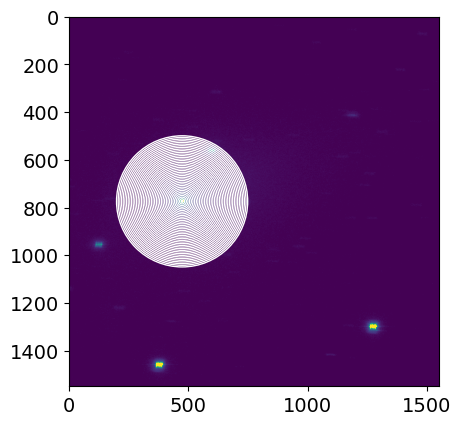

In [81]:
apRange, activityB, activityBError = FindActivityCurve(bImageStacked, cometB, apertureRange, zeroPoint=[bZeroPoint, bStd], phase=phase, exposureTime=len(vReducedDataPaths)*120, showPlot=True)

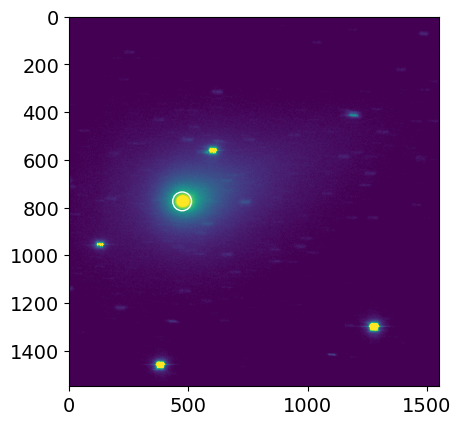

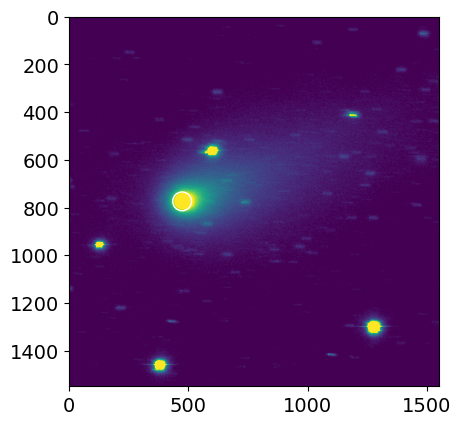

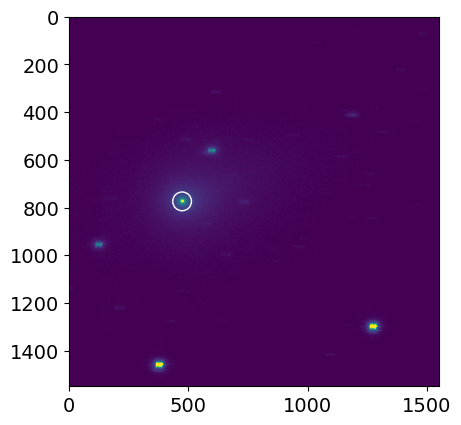

In [82]:
_, activityValueV, activityValueErrorV = FindActivityCurve(vImageStacked, cometV, [10000], zeroPoint=[vZeroPoint, vStd], phase=phase, exposureTime=len(vReducedDataPaths)*120, showPlot=True)
_, activityValueR, activityValueErrorR = FindActivityCurve(rImageStacked, cometR, [10000], zeroPoint=[rZeroPoint, rStd], phase=phase, exposureTime=len(vReducedDataPaths)*120, showPlot=True)
_, activityValueB, activityValueErrorB = FindActivityCurve(bImageStacked, cometB, [10000], zeroPoint=[bZeroPoint, bStd], phase=phase, exposureTime=len(vReducedDataPaths)*120, showPlot=True)

In [83]:
def SaveActivityData(outputPath, apertureRange, activities, errors):

    data = np.array([apertureRange, activities[0], activities[1], activities[2], errors[0], errors[1], errors[2]]).T

    np.savetxt(outputPath, data)

SaveActivityData(f"../DataProducts/Activity/{day}", apRange, [activityV, activityR, activityB], [activityVError, activityRError, activityBError])

activityValues = np.array([[10000]*3, [activityValueV[0], activityValueR[0], activityValueB[0]], [activityValueErrorV[0], activityValueErrorR[0], activityValueErrorB[0]]]).T

np.savetxt(f"../DataProducts/Activity/Evolution/{day}", activityValues)

## Plotting

Text(0.5, 1.0, 'Activity Curve for 2024-03-14')

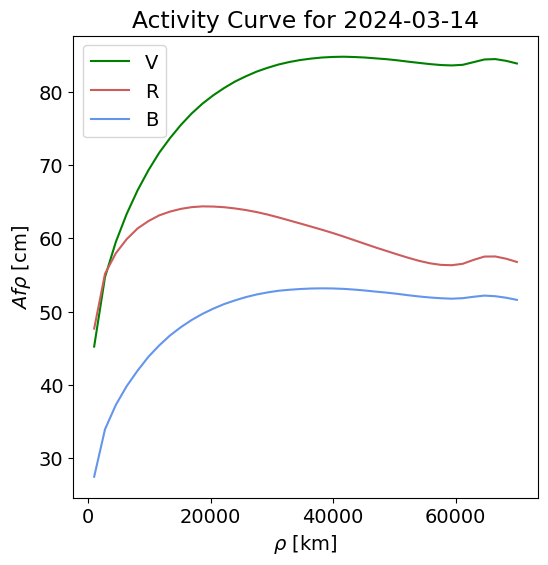

In [84]:
ctk.PlotAfrho(apRange, activityV, activityR, activityB, colours=["green", "indianred", "cornflowerblue"], figsize=(6,6))
plt.title(f"Activity Curve for 2024-03-{Day[3:]}")

# Activity Evolution Plot

../DataProducts/Activity/day12
../DataProducts/Activity/day13
../DataProducts/Activity/day14
../DataProducts/Activity/day17


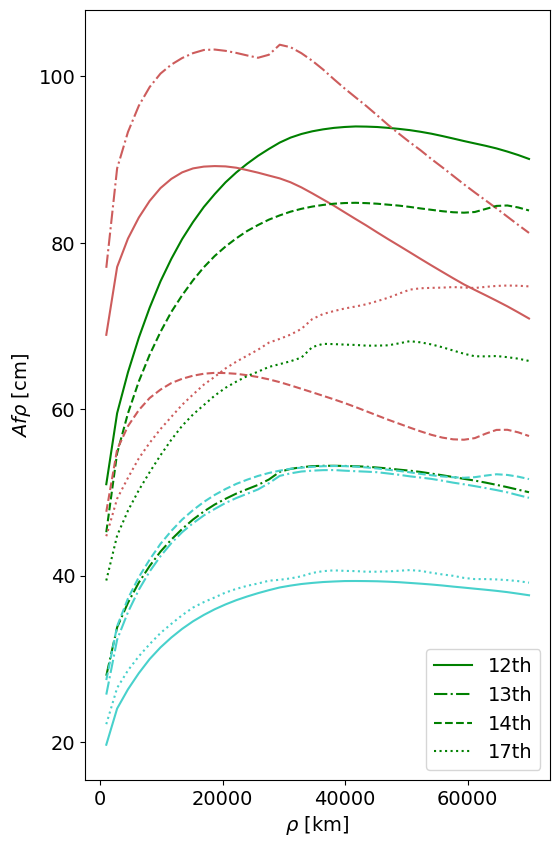

In [85]:
# Multiplot

from matplotlib import cm

# Loading data
dataPaths = natsorted(glob("../DataProducts/Activity/*"))[1:]
dayLabels = [path.split("/")[-1][3:] + "th" for path in dataPaths]

fig, ax = plt.subplots(figsize=(6,10))

lineStyles = ["solid", "dashdot", "dashed", "dotted"]
colours = ["green", "indianred", "mediumturquoise"]
#cmaps = [cm.get_cmap("summer"), cm.get_cmap("autumn"), cm.get_cmap("bone")]

for i, path in enumerate(dataPaths):

    print(path)

    data = np.loadtxt(path)

    apertures = data[:,0]
    activityV = data[:,1]
    activityR = data[:,2]
    activityB = data[:,3]

    ax.plot(apertures, activityV, color=colours[0], ls=lineStyles[i], label=dayLabels[i])
    ax.plot(apertures, activityR, color=colours[1], ls=lineStyles[i])
    ax.plot(apertures, activityB, color=colours[2], ls=lineStyles[i])

ax.set_ylabel(r"$Af\rho$ [cm]")
ax.set_xlabel(r"$\rho$ [km]")
ax.legend()

../DataProducts/Activity/day12
../DataProducts/Activity/day13
../DataProducts/Activity/day14
../DataProducts/Activity/day17


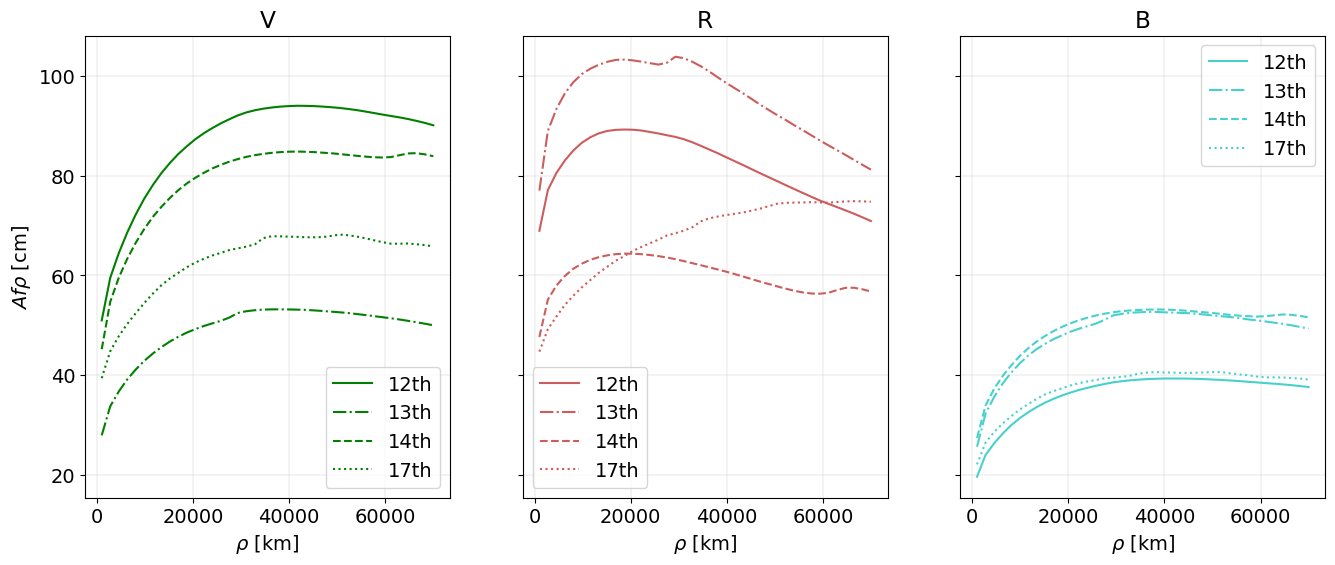

In [86]:
fig, axes = plt.subplots(1, 3, figsize=(16,6), sharey=True)

ax0, ax1, ax2 = axes

lineStyles = ["solid", "dashdot", "dashed", "dotted"]
colours = ["green", "indianred", "mediumturquoise"]
#cmaps = [cm.get_cmap("summer"), cm.get_cmap("autumn"), cm.get_cmap("bone")]

for i, path in enumerate(dataPaths):

    print(path)

    data = np.loadtxt(path)

    apertures = data[:,0]
    activityV = data[:,1]
    activityR = data[:,2]
    activityB = data[:,3]

    ax0.errorbar(apertures, activityV, color=colours[0], ls=lineStyles[i], label=dayLabels[i])
    ax1.errorbar(apertures, activityR, color=colours[1], ls=lineStyles[i], label=dayLabels[i])
    ax2.errorbar(apertures, activityB, color=colours[2], ls=lineStyles[i], label=dayLabels[i])

ax0.set_ylabel(r"$Af\rho$ [cm]")

ax0.set_title("V")
ax1.set_title("R")
ax2.set_title("B")

for ax in axes:
    ax.set_xlabel(r"$\rho$ [km]")
    ax.legend()
    ax.grid(lw=0.2)
    #ax.set_ylim(0, 60)

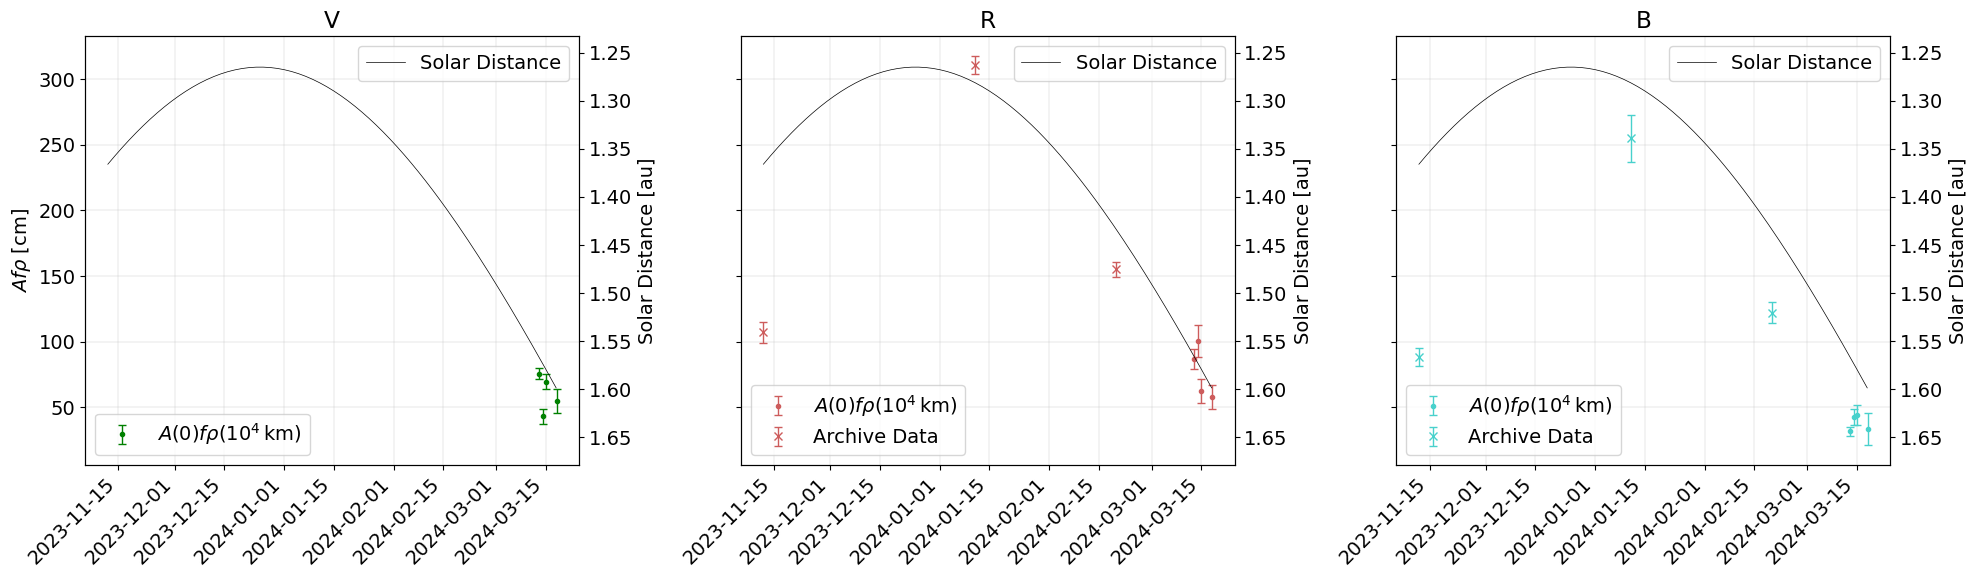

In [98]:
# Evolution. Standard reference aperture is 10^4 km, i.e. for 

from datetime import datetime
import matplotlib.dates as mdates

from astroquery.jplhorizons import Horizons # for ephemeris 

days = [13, 14, 15, 18]
times = [2, 4, 2, 3]
dates = [datetime(2024, 3, d, hour=t) for d, t in zip(days, times)]

# Extracting Data from files
evolutionData = [np.loadtxt(path) for path in natsorted(glob("../DataProducts/Activity/Evolution/*"))]

vData = []
rData = []
bData = []
vErrors = []
rErrors = []
bErrors = []
for i, data in enumerate(evolutionData):

    vData.append(data[0][1])
    rData.append(data[1][1])
    bData.append(data[2][1])

    vErrors.append(data[0][2])
    rErrors.append(data[1][2])
    bErrors.append(data[2][2])


# Archive data: https://www.astronomerstelegram.org/
archiveDates = [datetime(2024, 2, 20), datetime(2024, 1, 11), datetime(2023, 11, 12)]
archiveDataR = [155, 311, 107]
archiveDataRError = [6, 7, 8]
archiveDataB = [122, 255, 88]
archiveDataBError = [8, 18, 7]

colouredData = [vData, rData, bData]
colouredDataErrors = [vErrors, rErrors, bErrors]
archiveColouredData = [[None, None], [archiveDataR, archiveDataRError], [archiveDataB, archiveDataBError]]

# Ephemeris
body = Horizons(id=90000670, location="500@10", epochs={'start':"2023-11-12", 'stop':"2024-03-18", 'step':'24h'})
vectors = body.vectors()

ephemerisDates = [datetime.strptime(dateString, "A.D. %Y-%b-%d 00:00:00.0000") for dateString in vectors["datetime_str"]]
solarDistance = vectors["range"]


# Ploting

fig, axes = plt.subplots(1, 3, figsize=(20,6), sharey=True)

ax0, ax1, ax2 = axes


for i, ax in enumerate(axes):
    twinAx = ax.twinx()

    ax.errorbar(dates, colouredData[i], yerr=colouredDataErrors[i], fmt=".", capsize=3, lw=1, color=colours[i], label=r"$A(0)f\rho(10^4\,\text{km})$")
    
    if i != 0: # ... no archive data in V :/
        ax.errorbar(archiveDates, archiveColouredData[i][0], yerr=archiveColouredData[i][1], capsize=3, lw=1, color=colours[i], fmt="x", label="Archive Data")

    twinAx.plot(ephemerisDates, solarDistance, color="black", lw=0.5, zorder=5, label="Solar Distance")
    twinAx.set_ylim(np.max(solarDistance) + 0.05*np.max(solarDistance), np.min(solarDistance) - 0.02 * np.max(solarDistance))

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.legend(loc="lower left")
    twinAx.legend(loc="upper right")
    twinAx.set_ylabel("Solar Distance [au]")
    ax.grid(lw=0.2)


ax0.set_ylabel(r"$Af\rho$ [cm]")

ax0.set_title("V")
ax1.set_title("R")
ax2.set_title("B")

fig.autofmt_xdate(rotation=45, ha="right")

plt.tight_layout()